# Cheminformatics Project: Predicting Aqueous Solubility using Linear Regression

Cheminformatics is an exciting field that combines chemistry with informatics by collecting, storing, analysing and manipulating chemical data. Cheminformatics originally emerged to aid and inform drug discovery, however it has now grown to involve important areas of biology, chemistry and biochemistry, with many similarities to the field of bioinformatics.

In this project we will first try to replicate, and then improve upon, research by John S. Delaney [1], who used linear regression to predict the aqueous solubility (which he calls ESOL values) of a range of molecules. Delaney demonstrates that you can predict the solubility to a reasonable accuracy using 4 easily observable features: molecular weight, number of rotatable bonds, aromatic proportion and the octane-water partition coefficient.

Aqueous solubility is one of the key physical properties of interest to a medicinal chemist as it affects the uptake/distribution of biologically active compounds within the body.

Finally, I would like to thank Prof. Jan H. Jensen [2] for the idea for this notebook and for his excellent tutorials on the use of machine learning within chemistry.

## Contents

**Libraries**

**1.0 Reproducing Delaney's Results**
1.1 Data Creation
1.2 Data Analysis
1.3 Model
1.4 Evaluation

**2.0 Improving upon Delaney's Results**
2.1 Additional Data Creation
2.2 Additional Data Analysis
2.3 Model
2.3.1 Additional Features
2.3.2 Tuning Hyper Parameters
2.4 Evaluation
2.5 Conclusion

**References**

In [1]:
# for kaggle
# import os
# !conda install -c rdkit rdkit -y

**Libraries**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from math import ceil

from rdkit.Chem import PandasTools, Descriptors, rdMolDescriptors

import sklearn.metrics
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [3]:
np.random.seed(3)

# 1.0 Reproducing Delaney's Results

# 1.1 Data Creation

**Importing Delaney's Dataset**

The data used in Delany's regression can be found in his paper's [supporting information](https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt) as a csv. However, it is also possible to generate all of these features using the python cheminformatics library, RDKit. Molecules are most commonly input into RDKit SMILE (Simplified Molecular-Input Line-Entry System) strings, which are used to create RDKit objects.

In [4]:
# !python -m wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

In [5]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [6]:
df = pd.read_csv('delaney-processed.csv',
                 usecols=['Compound ID',
                          'smiles',
                          'ESOL predicted log solubility in mols per litre',
                          'measured log solubility in mols per litre'])

df = df.rename(columns={'Compound ID':'Name',
                        'ESOL predicted log solubility in mols per litre':'ESOL Predicted log(solubility/M)',
                        'measured log solubility in mols per litre':'Measured log(solubility/M)'})
# Molar (M) is an equivalent unit to mols per litre (or dm^3).
df.head()

,Name,ESOL Predicted log(solubility/M),Measured log(solubility/M),smiles
0,Amigdalin,-0.974,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,-1.33,c1ccsc1


**Deriving Inputs from RDKit**

Using the SMILE strings we will create an RDKit object for each molecule. This then allows us to generate all of the features we'll need with just a few lines of code. This is the essence of Delaney's paper, providing a way to predict solubility values using only easily generated features.

In [7]:
# Type: rdkit.Chem.rdchem.Mol, displayed as an image in df
PandasTools.AddMoleculeColumnToFrame(df, 'smiles', 'Molecule')

In [8]:
def aromatic_proportion(mol):
    
    aromatic_atoms = [mol.GetAtomWithIdx(i).GetIsAromatic() for i in range(mol.GetNumAtoms())] #returns bool for each atom
    aromatic_count = sum(aromatic_atoms)
    heavy = Descriptors.HeavyAtomCount(mol)
    
    return aromatic_count / heavy

In [9]:
# molecular weight
mw_lst = [ Descriptors.MolWt(element) for element in df.Molecule ]
df['MW'] = np.array(mw_lst)

# number of rotatable bonds
rb_lst = [ Descriptors.NumRotatableBonds(element) for element in df.Molecule ]
df['RB'] = np.array(rb_lst)

# aromatic proportion 
ap_lst = [ aromatic_proportion(element) for element in df.Molecule ]
df['AP'] = np.array(ap_lst)

# octane-water partition coefficient
cLogP_lst = [ Descriptors.MolLogP(element) for element in df.Molecule ]
df['cLogP'] = np.array(cLogP_lst)

,Name,ESOL Predicted log(solubility/M),Measured log(solubility/M),smiles,Molecule,MW,RB,AP,cLogP
0,Amigdalin,-0.974,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,,457.432,7,0.187500,-3.10802
1,Fenfuram,-2.885,-3.30,Cc1occc1C(=O)Nc2ccccc2,,201.225,2,0.733333,2.84032
2,citral,-2.579,-2.06,CC(C)=CCCC(C)=CC(=O),,152.237,4,0.000000,2.87800
3,Picene,-6.618,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,,278.354,0,1.000000,6.29940
4,Thiophene,-2.232,-1.33,c1ccsc1,,84.143,0,1.000000,1.74810

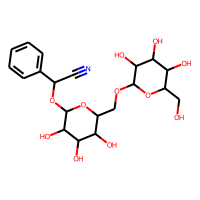
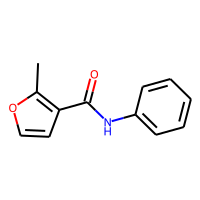
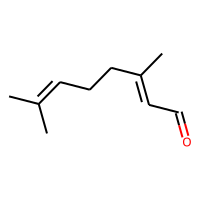
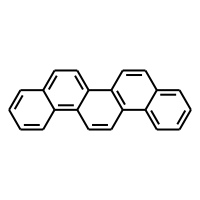
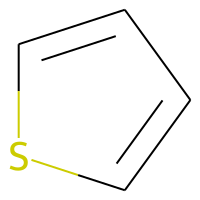

In [10]:
df.head()

Now that we have all of the training data needed, we can begin by replicating Delaney's results.

# 1.2 Data Analysis

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ESOL Predicted log(solubility/M),1128.0,-2.988192,1.683220,-9.7020,-3.94825,-2.870,-1.843750,1.0910
Measured log(solubility/M),1128.0,-3.050102,2.096441,-11.6000,-4.31750,-2.860,-1.600000,1.5800
MW,1128.0,203.937074,102.738077,16.0430,121.18300,182.179,270.372000,780.9490
RB,1128.0,2.177305,2.640974,0.0000,0.00000,1.000,3.000000,23.0000
AP,1128.0,0.363544,0.343778,0.0000,0.00000,0.375,0.666667,1.0000
cLogP,1128.0,2.447520,1.852875,-7.5714,1.41490,2.339,3.402200,10.3886


First we will plot histograms and scatter plots for each feature to gain an overview of the characteristics of the molecules in the dataset.

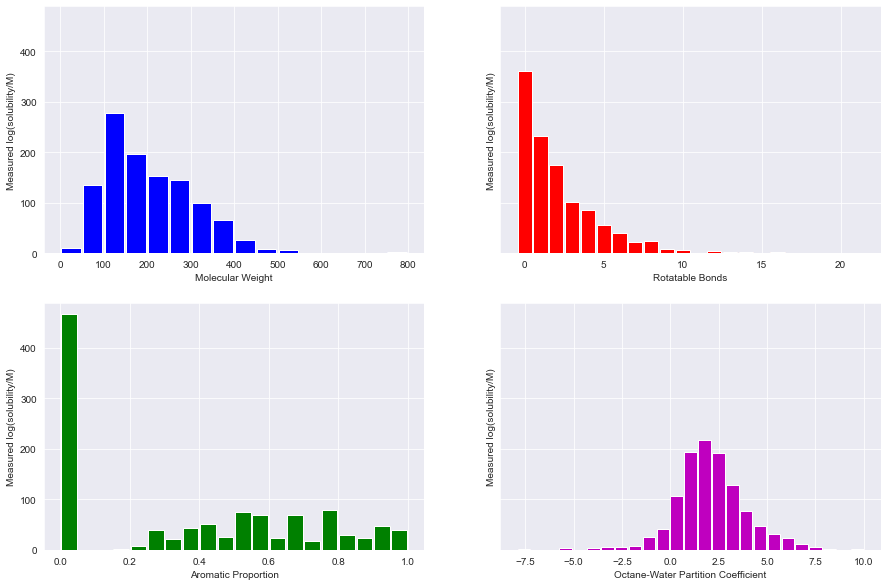

In [12]:
# histograms of each variable and the measured log solubility
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10), sharey=True)

ax1 = ax[0,0]
ax1.hist(df['MW'], bins=list(range(0,850,50)), rwidth=0.9, color='b')
ax1.set_xlabel('Molecular Weight')
ax1.set_ylabel('Measured log(solubility/M)')

ax2 = ax[0,1]
ax2.hist(df['RB'], bins=list(range(23)), align='left', rwidth=0.9, color='r')
ax2.set_xlabel('Rotatable Bonds')
ax2.set_ylabel('Measured log(solubility/M)')

ax3 = ax[1,0]
ax3.hist(df['AP'], bins=20, rwidth=0.9, color='g')
ax3.set_xlabel('Aromatic Proportion')
ax3.set_ylabel('Measured log(solubility/M)')

ax4 = ax[1,1]
ax4.hist(df['cLogP'], bins=25, align='left', rwidth=0.9, color='m')
ax4.set_xlabel('Octane-Water Partition Coefficient')
ax4.set_ylabel('Measured log(solubility/M)')

plt.show()

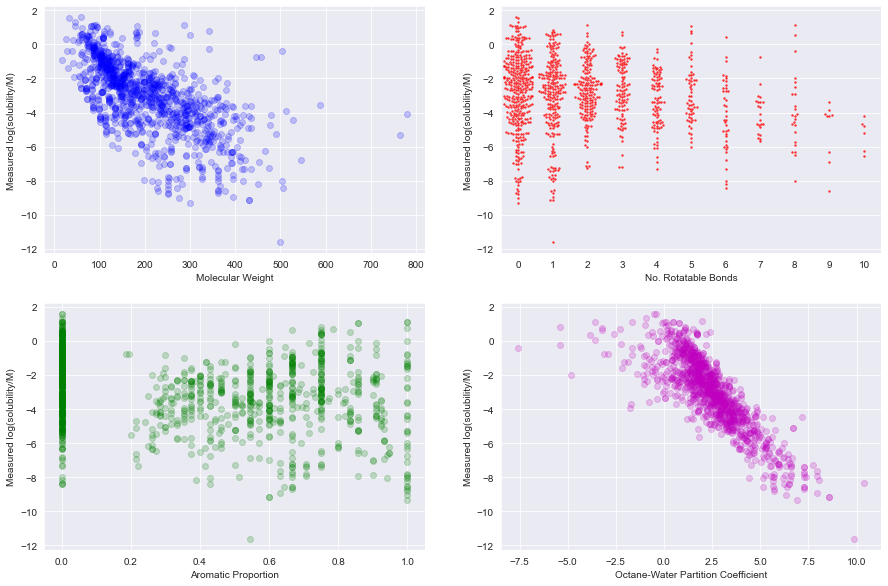

In [13]:
# scatter plot for each variable and the log solubility
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

ax1 = ax[0,0]
ax1.scatter(df['MW'], df['Measured log(solubility/M)'], c='b', alpha=0.2)
ax1.set_xlabel('Molecular Weight')
ax1.set_ylabel('Measured log(solubility/M)')

ax2 = ax[0,1]
sns.swarmplot(data=df[df.RB<11], x='RB', y='Measured log(solubility/M)', ax=ax[0,1], c='r', s=2.4, alpha=0.8)
# values above 10 not shown as there are less than 5 molecules for each of these values
ax2.set_xlabel('No. Rotatable Bonds')
ax2.set_ylabel('Measured log(solubility/M)')

ax3 = ax[1,0]
ax3.scatter(df['AP'], df['Measured log(solubility/M)'], c='g', alpha=0.2)
ax3.set_xlabel('Aromatic Proportion')
ax3.set_ylabel('Measured log(solubility/M)')

ax4 = ax[1,1]
ax4.scatter(df['cLogP'], df['Measured log(solubility/M)'], c='m', alpha=0.2)
ax4.set_xlabel('Octane-Water Partition Coefficient')
ax4.set_ylabel('Measured log(solubility/M)')

plt.show()

For discrete data, as in number of rotatable bonds, a swarm plot is used instead of a scatter plot.

Even before training our algorithm we can see that the octane-water partition coefficient is likely to be an important factor in the regression as it has a clear linear correlation.

# 1.3 Model

We will first train a linear regression using the four features from Delaney's paper.

In [14]:
X = df[['MW', 'RB', 'AP', 'cLogP']]

Y = df['Measured log(solubility/M)']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [15]:
%%time
model = LinearRegression()
k = 10
repeats = 3
cv = RepeatedKFold(n_splits=k, n_repeats=repeats, random_state=1)
scores = cross_validate(model, X_train, Y_train, cv=cv,
                        scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'))
model.fit(X_train, Y_train)
Y_pred_test = model.predict(X_test)

Wall time: 251 ms


In [16]:
# metrics
mse = -np.mean(scores["test_neg_mean_squared_error"])
mae = -np.mean(scores["test_neg_mean_absolute_error"])
r2 = np.mean(scores["test_r2"])
# standard errors of metrics
mse_se = np.std(scores["test_neg_mean_squared_error"])/np.sqrt(k*repeats)
mae_se = np.std(scores["test_neg_mean_absolute_error"])/np.sqrt(k*repeats)
r2_se = np.std(scores["test_r2"])/np.sqrt(k*repeats)

print(f'Mean squared error (MSE): {mse:.2f} ± {ceil(mse_se*100)/100:.2f}')
print(f'Mean absolute error (MAE): {mae:.2f} ± {ceil(mae_se*100)/100:.2f}')
print(f'Coefficient of determination (R^2): {r2:.2f} ± {ceil(r2_se*100)/100:.2f}')

Mean squared error (MSE): 1.01 ± 0.05
Mean absolute error (MAE): 0.78 ± 0.02
Coefficient of determination (R^2): 0.77 ± 0.01


In [17]:
Delaney_sklearn = { 'model':'sklearn_basic',
                    'MSE':mse,
                    'MAE':mae,
                    'R^2':r2,
                    'MSE_se': mse_se,
                    'MAE_se': mae_se,
                    'R^2_se': r2_se,
                    'intercept':model.intercept_,
                    'MW':model.coef_[0],
                    'RB':model.coef_[1],
                    'AP':model.coef_[2],
                    'cLogP':model.coef_[3] }

# 1.4 Evaluation

In [18]:
# calculate delaney's stats
delaney_error = df['Measured log(solubility/M)']-df['ESOL Predicted log(solubility/M)']
d_mse = np.mean(delaney_error**2)
d_mae = np.mean(abs(delaney_error))

diff = df['Measured log(solubility/M)']-df['ESOL Predicted log(solubility/M)'].mean()
d_r2 = 1 - (np.sum(delaney_error**2)/np.sum(diff**2))

Delaney_literature = {'model':'literature',
                      'MSE':d_mse,
                      'MAE':d_mae,
                      'R^2':d_r2,
                      'MSE_se': np.nan,
                      'MAE_se': np.nan,
                      'R^2_se': np.nan,
                      'intercept':0.16,
                      'MW':-0.0062,
                      'RB':0.066,
                      'AP':-0.74,
                      'cLogP':-0.63 }

In [19]:
results = pd.DataFrame([Delaney_literature, Delaney_sklearn]).set_index('model')
results

,MSE,MAE,R^2,MSE_se,MAE_se,R^2_se,intercept,MW,RB,AP,cLogP
model,,,,,,,,,,,
literature,0.828341,0.697862,0.811527,NaN,NaN,NaN,0.160000,-0.006200,0.066000,-0.740000,-0.630000
sklearn_basic,1.010852,0.776142,0.773454,0.041812,0.013645,0.009564,0.275705,-0.006658,0.003953,-0.410378,-0.735215


 Before plotting the weights of each feature we shall normalise them by multiply them by their mean. Otherwise features such as molecular weight, that has a large mean of 204, will appear to have contributed less to the model than other feature.

In [20]:
norm_results = results
for feature in df.columns:
    if feature in norm_results.columns:
        norm_results[feature] = norm_results[feature] * df[feature].mean()
norm_results

,MSE,MAE,R^2,MSE_se,MAE_se,R^2_se,intercept,MW,RB,AP,cLogP
model,,,,,,,,,,,
literature,0.828341,0.697862,0.811527,NaN,NaN,NaN,0.160000,-1.264410,0.143702,-0.269022,-1.541937
sklearn_basic,1.010852,0.776142,0.773454,0.041812,0.013645,0.009564,0.275705,-1.357754,0.008606,-0.149190,-1.799454


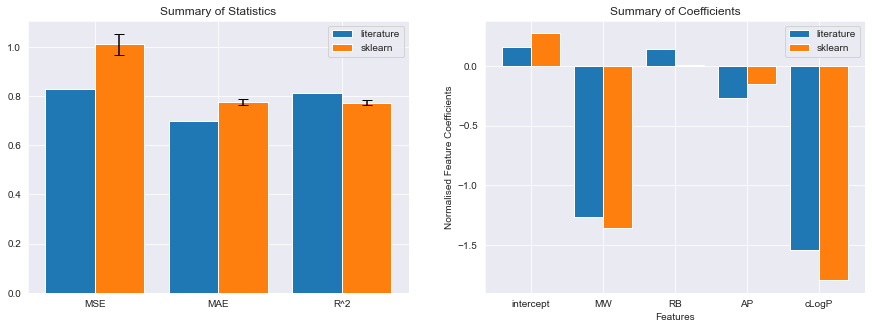

In [21]:
# Plot of a summary of the three models
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
width = 0.4

# summary of statistics
ax1 = ax[0]

X = results.columns[:3]
X_axis = np.arange(len(X))

ax1.bar(X_axis-width/2, results.loc['literature'][:3], width=width, label = 'literature')
ax1.bar(X_axis+width/2, results.loc['sklearn_basic'][:3], width=width, label = 'sklearn', yerr=results.loc['sklearn_basic'][3:6], capsize=5)

ax1.set_xticks(X_axis, X)
ax1.set_title("Summary of Statistics")
ax1.legend()

# summary of coefficients
ax2 = ax[1]

X = results.columns[6:]
X_axis = np.arange(len(X))

ax2.bar(X_axis-width/2, norm_results.loc['literature'][6:], width=width, label = 'literature')
ax2.bar(X_axis+width/2, norm_results.loc['sklearn_basic'][6:], width=width, label = 'sklearn')

ax2.set_xticks(X_axis, X)
ax2.set_title("Summary of Coefficients")
ax2.set_ylabel('Normalised Feature Coefficients')
ax2.set_xlabel('Features')
ax2.legend()

plt.show()

The major points demonstrated by the summary of statistics are:
- Delaney's model is significantly more accurate for across all indicators
- Errors for MAE and R^2 are smaller by a factor of 3 than the errors for MSE.

And the main points from the summary of coefficients are:
- As suggested by the scatter plots, the octane-water partition coefficient and molecular weight are given the most weight in my models.
- The coefficient for the number of rotatable bonds, although still small, is an order of magnitude higher is Delaney's AND the opposite sign.

These observed differences between mine and Delaney's models can be explained in part by the difference in training set size. Delaney had 2874 molecules, whereas the supplementary information only gives us access to 1128.

# 2.0 Improving upon Delaney's Results

We shall now try to optimise our linear regression to see if we can improve on it's accuaracy and perhaps even beat Delaney's model.

# 2.1 Additional Data Creation

One simple way to improve a linear regression is to add more features (up to a certain point). We will try adding 3 more descriptors using RDKit: number of rings, number of H bond donors and the topological polar surface area.

In [22]:
# number of rings
rings_lst = [ rdMolDescriptors.CalcNumRings(element) for element in df.Molecule ]
df['RINGS'] = np.array(rings_lst)

# number of H bond donors
hbd_lst = [ rdMolDescriptors.CalcNumHBD(element) for element in df.Molecule ]
df['HBD'] = np.array(hbd_lst)

# topological polar surface area
psa_lst = [ Descriptors.TPSA(element) for element in df.Molecule ]
df['PSA'] = np.array(psa_lst)

# 2.2 Additional Data Analysis

Once again we will plot these new features to give an indication of their distributions.

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ESOL Predicted log(solubility/M),1128.0,-2.988192,1.683220,-9.7020,-3.94825,-2.870,-1.843750,1.0910
Measured log(solubility/M),1128.0,-3.050102,2.096441,-11.6000,-4.31750,-2.860,-1.600000,1.5800
MW,1128.0,203.937074,102.738077,16.0430,121.18300,182.179,270.372000,780.9490
RB,1128.0,2.177305,2.640974,0.0000,0.00000,1.000,3.000000,23.0000
AP,1128.0,0.363544,0.343778,0.0000,0.00000,0.375,0.666667,1.0000
cLogP,1128.0,2.447520,1.852875,-7.5714,1.41490,2.339,3.402200,10.3886
RINGS,1128.0,1.390957,1.318286,0.0000,0.00000,1.000,2.000000,8.0000
HBD,1128.0,0.701241,1.089727,0.0000,0.00000,0.000,1.000000,11.0000
PSA,1128.0,34.872881,35.383593,0.0000,0.00000,26.300,55.440000,268.6800


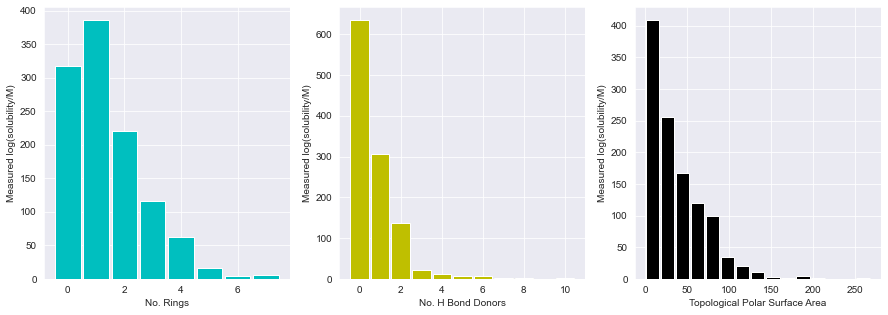

In [24]:
# histograms of each variable and the log solubility
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

ax1 = ax[0]
ax1.hist(df['RINGS'], bins=8, align='left', rwidth=0.9, color='c')
ax1.set_xlabel('No. Rings')
ax1.set_ylabel('Measured log(solubility/M)')

ax2 = ax[1]
ax2.hist(df['HBD'], bins=11, align='left', rwidth=0.9, color='y')
ax2.set_xlabel('No. H Bond Donors')
ax2.set_ylabel('Measured log(solubility/M)')

ax3 = ax[2]
ax3.hist(df['PSA'], bins=15, rwidth=0.9, color='k')
ax3.set_xlabel('Topological Polar Surface Area')
ax3.set_ylabel('Measured log(solubility/M)')

plt.show()

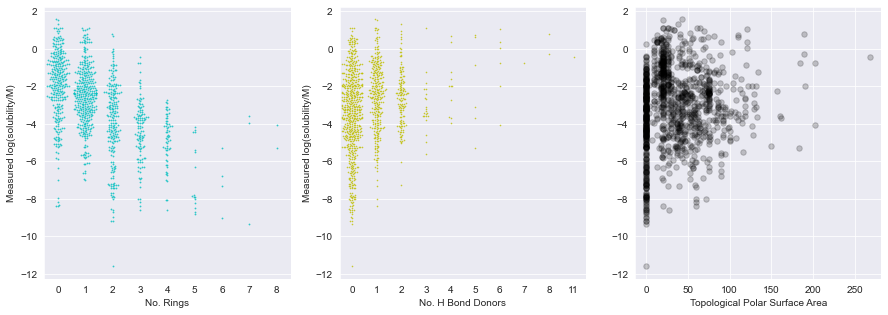

In [25]:
# scatter plot for each variable and the log solubility
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

ax1 = ax[0]
sns.swarmplot(data=df, x='RINGS', y='Measured log(solubility/M)', ax=ax[0], c='c', s=1.8, alpha=0.8)
ax1.set_xlabel('No. Rings')
ax1.set_ylabel('Measured log(solubility/M)')

ax2 = ax[1]
sns.swarmplot(data=df, x='HBD', y='Measured log(solubility/M)', ax=ax[1], c='y', s=1.6, alpha=0.8)
ax2.set_xlabel('No. H Bond Donors')

ax3 = ax[2]
ax3.scatter(df['PSA'], df['Measured log(solubility/M)'], c='k', alpha=0.2, s=30)
ax3.set_xlabel('Topological Polar Surface Area')

plt.show()

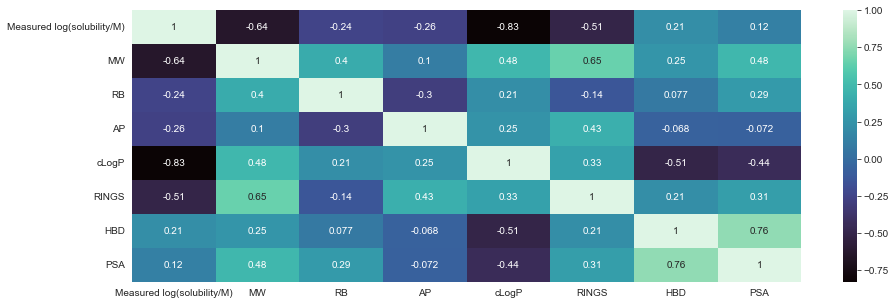

In [26]:
# correlation table
corr = df[['Measured log(solubility/M)', 'MW', 'RB', 'AP', 'cLogP', 'RINGS', 'HBD', 'PSA']].corr()
plt.figure(figsize=(15,5))
sns.heatmap(corr, cmap='mako', annot=True)
plt.show()

Correlation plots are useful for checking for collinearity between features. This plot demonstrates why cLogP is given the most weight within the linear regression, as it has an absolute correlation of 0.83.

# 2.3 Model

**2.3.1 Additional Features**

We will now train a new model with these additional features to see if it improves the accuracy.

In [27]:
X = df[['MW', 'RB', 'AP', 'cLogP', 'RINGS', 'HBD', 'PSA']]

Y = df['Measured log(solubility/M)']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [28]:
%%time
model = LinearRegression()
cv = RepeatedKFold(n_splits=k, n_repeats=repeats, random_state=1)
scores = cross_validate(model, X_train, Y_train, cv=cv,
                        scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'))
model.fit(X_train, Y_train)
Y_pred_test = model.predict(X_test)

Wall time: 235 ms


In [29]:
# metrics
mse = -np.mean(scores["test_neg_mean_squared_error"])
mae = -np.mean(scores["test_neg_mean_absolute_error"])
r2 = np.mean(scores["test_r2"])
# standard errors of metrics
mse_se = np.std(scores["test_neg_mean_squared_error"]) / np.sqrt(k*repeats)
mae_se = np.std(scores["test_neg_mean_absolute_error"]) / np.sqrt(k*repeats)
r2_se = np.std(scores["test_r2"]) / np.sqrt(k*repeats)

print(f'Mean squared error (MSE): {mse:.2f} ± {ceil(mse_se * 100) / 100:.2f}')
print(f'Mean absolute error (MAE): {mae:.2f} ± {ceil(mae_se * 100) / 100:.2f}')
print(f'Coefficient of determination (R^2): {r2:.2f} ± {ceil(r2_se * 100) / 100:.2f}')

Mean squared error (MSE): 0.99 ± 0.04
Mean absolute error (MAE): 0.78 ± 0.02
Coefficient of determination (R^2): 0.76 ± 0.02


In [30]:
improved_sklearn = {'model': 'sklearn_improved',
                    'MSE': mse,
                    'MAE': mae,
                    'R^2': r2,
                    'MSE_se': mse_se,
                    'MAE_se': mae_se,
                    'R^2_se': r2_se,
                    'intercept': model.intercept_,
                    'MW': model.coef_[0],
                    'RB': model.coef_[1],
                    'AP': model.coef_[2],
                    'cLogP': model.coef_[3],
                    'RINGS':model.coef_[4],
                    'HBD':model.coef_[5],
                    'PSA':model.coef_[6]}

**2.3.2 Tuning Hyper Parameters**

Although linear regression has very few hyper-parameters, the choice of features is something we can tune. This may increase the accuracy of our plot, particularly as certain features (such as PSA and HBD) are quite highly correlated. We will do this using recursive feature elimination (RFE). Choosing fewer features can allow machine learning algorithms to run more efficiently (less space or time complexity) and be more effective.

First RFECV (recursive feature elimination cross validation) can be used to select the best model and best number of features. This is done by recursively reducing the number of features chosen until the accuracy decreases. Then we will take the best model and see how it ranks features and what the optimum number of features is.

MAE will be used to compare models as it has a substantially lower standard error than MSE.

In [31]:
%%time

results, names = [], []

models = {'lr': LinearRegression(),
          'tree': DecisionTreeRegressor(),
          'rf': RandomForestRegressor(),
          'gbm': GradientBoostingRegressor()}

results, names = [], []
for name, feature_selection in models.items():

    rfecv = RFECV(estimator=feature_selection)
    rfecv.fit(X_train, Y_train)
    model = LinearRegression()
    pipe = Pipeline(steps=[('s',rfecv),('m',model)])

    cv = RepeatedKFold(n_splits=k, n_repeats=repeats, random_state=1)
    scores = -cross_val_score(pipe, X_train, Y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

    results.append(scores)
    names.append(name)

    print(f'> model: {name}, {sum(rfecv.support_)} features, mse: {np.mean(scores):.3f} ± {np.std(scores)/np.sqrt(k*repeats):.3f}')

> model: lr, 7 features, mse: 0.993 ± 0.039
> model: tree, 6 features, mse: 1.006 ± 0.038
> model: rf, 6 features, mse: 0.999 ± 0.039
> model: gbm, 7 features, mse: 0.998 ± 0.039
Wall time: 4min 2s


Linear regression with all 7 features performs the best out of the models tested. However, it's worth noting that all models tested are within the standard error of the linear regression and so the choice of model is somewhat arbitrary.

Anyway, let's see how the number of features affects the MSE.

In [32]:
# get a list of models to evaluate
models = {}
results, names = [], []
for i in range(2, X_train.shape[1]+1):

    rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)
    model = LinearRegression()
    pipe = Pipeline(steps=[('s',rfe),('m',model)])

    cv = RepeatedKFold(n_splits=k, n_repeats=repeats, random_state=1)
    scores = -cross_val_score(pipe, X_train, Y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

    results.append(scores)
    names.append(i)

    print(f'>no. features: {i}, mse: {np.mean(scores):.3f} ± {np.std(scores)/np.sqrt(k*repeats):.3f}')

>no. features: 2, mse: 1.175 ± 0.040
>no. features: 3, mse: 1.055 ± 0.040
>no. features: 4, mse: 1.028 ± 0.038
>no. features: 5, mse: 1.017 ± 0.039
>no. features: 6, mse: 1.008 ± 0.038
>no. features: 7, mse: 0.993 ± 0.038


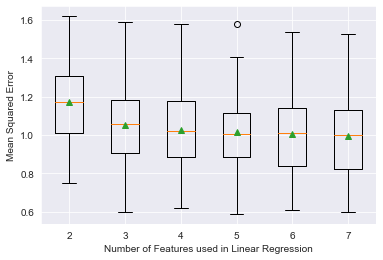

In [33]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.xlabel('Number of Features used in Linear Regression')
plt.ylabel('Mean Squared Error')
plt.show()

The most accurate linear regression is the one with all 7 features (i.e. our sklearn_improved model). However, this is still a useful check to have done since several features had relatively high correlations (e.g. 0.73 for PSA and HBD).

# 2.4 Evaluation

In [34]:
results = pd.DataFrame([Delaney_literature, Delaney_sklearn, improved_sklearn]).set_index('model')
results

,MSE,MAE,R^2,MSE_se,MAE_se,R^2_se,intercept,MW,RB,AP,cLogP,RINGS,HBD,PSA
model,,,,,,,,,,,,,,
literature,0.828341,0.697862,0.811527,NaN,NaN,NaN,0.160000,-0.006200,0.066000,-0.740000,-0.630000,NaN,NaN,NaN
sklearn_basic,1.010852,0.776142,0.773454,0.041812,0.013645,0.009564,0.275705,-0.006658,0.003953,-0.410378,-0.735215,NaN,NaN,NaN
sklearn_improved,0.993301,0.783518,0.757796,0.038475,0.014038,0.010385,0.252234,-0.002577,-0.036155,-0.034426,-0.873908,-0.23711,-0.155678,-0.002947


In [35]:
norm_results = results
for feature in df.columns:
    if feature in norm_results.columns:
        norm_results[feature] = norm_results[feature] * df[feature].mean()
norm_results

,MSE,MAE,R^2,MSE_se,MAE_se,R^2_se,intercept,MW,RB,AP,cLogP,RINGS,HBD,PSA
model,,,,,,,,,,,,,,
literature,0.828341,0.697862,0.811527,NaN,NaN,NaN,0.160000,-1.264410,0.143702,-0.269022,-1.541937,NaN,NaN,NaN
sklearn_basic,1.010852,0.776142,0.773454,0.041812,0.013645,0.009564,0.275705,-1.357754,0.008606,-0.149190,-1.799454,NaN,NaN,NaN
sklearn_improved,0.993301,0.783518,0.757796,0.038475,0.014038,0.010385,0.252234,-0.525481,-0.078720,-0.012515,-2.138906,-0.32981,-0.109168,-0.102774


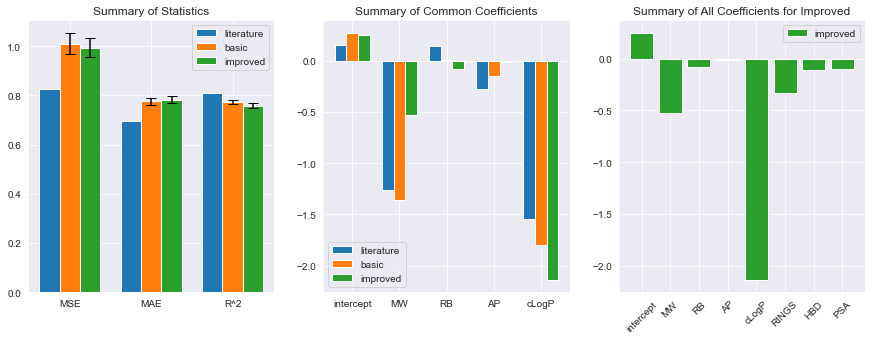

In [36]:
# Plot of a summary of the three models
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
width = 0.25

# summary of statistics
ax1 = ax[0]

X = results.columns[:3]
X_axis = np.arange(len(X))

ax1.bar(X_axis-width, results.loc['literature'][:3], width=width, label = 'literature')
ax1.bar(X_axis, results.loc['sklearn_basic'][:3], width=width, label = 'basic', yerr=results.loc['sklearn_basic'][3:6], capsize=5)
ax1.bar(X_axis+width, results.loc['sklearn_improved'][:3], width=width, label = 'improved', yerr=results.loc['sklearn_improved'][3:6], capsize=5)

ax1.set_xticks(X_axis, X)
ax1.set_title("Summary of Statistics")
ax1.legend()

# summary of common coefficients
ax2 = ax[1]

X = results.columns[6:11]
X_axis = np.arange(len(X))

ax2.bar(X_axis-width, norm_results.loc['literature'][6:11], width=width, label = 'literature')
ax2.bar(X_axis, norm_results.loc['sklearn_basic'][6:11], width=width, label = 'basic')
ax2.bar(X_axis+width, norm_results.loc['sklearn_improved'][6:11], width=width, label = 'improved')

ax2.set_xticks(X_axis, X)
ax2.set_title("Summary of Common Coefficients")
ax2.legend()

# summary of all coefficients for improved sklearn
ax3 = ax[2]

X = results.columns[6:]
X_axis = np.arange(len(X))

ax3.bar(X_axis, norm_results.loc['sklearn_improved'][6:], label = 'improved', color='tab:green')

ax3.set_xticks(X_axis, X, rotation=45, ha='center')
ax3.set_title("Summary of All Coefficients for Improved")
ax3.legend()
plt.show()

As you can see adding more features immediately reduces both the MSE (by 11%) and the MAE (by 4%). This also further increases the models reliance on the octane-water partition coefficient and reduces the reliance on aromatic proportion and molecular weight, moving further away from Delaney's coefficients.

This can be partially explained by the inclusion of the number of rings as a feature. Most rings will be aromatic and so rings and AP will be correlated to some degree. In fact, if you add together the coefficients for rings and aromatic proportion you get a value very close to that of the aromatic proportion coefficient for previous models.

We will now plot the absolute weights of each feature in order of RFE ranking to determine if there is a correlation.

       ranking   n=7    n=6    n=5    n=4    n=3    n=2    n=1
cLogP        1  True   True   True   True   True   True   True
HBD          2  True   True   True   True   True   True  False
RINGS        3  True   True   True   True   True  False  False
RB           4  True   True   True   True  False  False  False
AP           5  True   True   True  False  False  False  False
PSA          6  True   True  False  False  False  False  False
MW           7  True  False  False  False  False  False  False


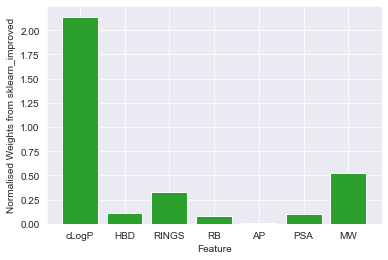

In [37]:
# report which features were selected by RFE
from sklearn.feature_selection import RFE

feature_selection = pd.DataFrame(index=X_train.columns)

for num in range(X_train.shape[1], 0, -1):
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=num)
    rfe.fit(X_train, Y_train)
    feature_selection['ranking'] = rfe.ranking_
    feature_selection[f'n={num}'] = rfe.support_

feature_selection = feature_selection.sort_values(by='ranking')
print(feature_selection)

plot = []
for feature in list(feature_selection.index):
    plot.append(abs(norm_results.loc['sklearn_improved', feature]))

X = list(feature_selection.index)
X_axis = np.arange(len(X))
plt.bar(X_axis, plot, label = 'improved', color='tab:green')
plt.xticks(X_axis, X)
plt.xlabel('Feature')
plt.ylabel('Normalised Weights from sklearn_improved')
plt.show()

Interestingly, while cLogP has both the largest absolute weight and RFE ranking, there seems to be very little correlation between the two.

For a final comparison we will plot predicted vs measure values for both Delaney's values and for our sklearn improved values.

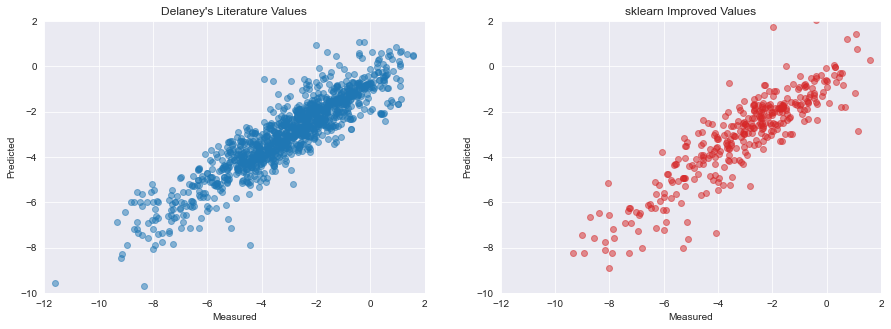

In [38]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

ax1 = ax[0]
ax1.scatter(df['Measured log(solubility/M)'], df['ESOL Predicted log(solubility/M)'], alpha=0.5)
ax1.set_xlabel('Measured')
ax1.set_ylabel('Predicted')
ax1.set_title("Delaney's Literature Values")
ax1.set_ylim(-10,2)
ax1.set_xlim(-12,2)

ax2 = ax[1]
ax2.scatter(Y_test, Y_pred_test, alpha=0.5, color='tab:red')
ax2.set_xlabel('Measured')
ax2.set_ylabel('Predicted')
ax2.set_title("sklearn Improved Values")
ax2.set_ylim(-10,2)
ax2.set_xlim(-12,2)

plt.show()

# 2.5 Conclusion

Despite the inclusion of additional features, we could not quite beat the accuracy of Delaney's model. As stated before this is most likely due to using a smaller training set. It is worth mentioning that while Delaney's data spans 13 logs of solubility, most experimental data will only span 2 or 3, meaning that even with a MAE of 0.70, Delaney's model is still only an estimate.

However, ESOL is a really quick, easy and useful technique for predicting aqueous solubility, particularly when developing new molecules. This is because the most widely used model for predicting aqueous solubility, the General Solubility Equation (GSE) relies on knowing the melting temperature of a molecule. While melting temperature can be measured for existing molecules, predicting it for *de novo* molecules is notoriously tricky and computationally expensive.

Thanks for reading!

# References

1. [ESOL: Estimating Aqueous Solubility Directly from Molecular Structure](https://pubs.acs.org/doi/10.1021/ci034243x), J. S. Delany, J. Chem. Inf. Comput. Sci. 2004, **44**, 1000-1005
2. [Machine Learning Basics by Jan H. Jensen](https://sites.google.com/view/ml-basics/home?authuser=0)